In [ ]:
import cosima_cookbook as cc
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cmocean as cm
from scipy.optimize import curve_fit
from xhistogram.xarray import histogram
from scipy.optimize import fsolve

from dask.distributed import Client

%matplotlib inline

### 1D model

In [27]:
# Constants, data, parameters

rho = 1035 # kg/m^3
c = 4000 # J/(kg C)

z_m = 25.0 # Depth of minimum mixing layer
z_d = 900.0 # Depth for deep ocean restoring term
z_b = 1000.0 # Depth of thermocline

lambd = 8/(1.2 - 1.0)
gamma = lambd / (rho*c*z_m)
kappa = 0
mu = 1/(5 * 365 * 86400)

T_0 = 22.0 # Top temperature for initial condition
T_b = 5.0 # Bottom temperature for initial condition (this warms up a bit during runs because of the no-flux at bottom condition)

dt = 10.0 * 86400 # units: s
dz = 5.0 # units: m

z = np.linspace(0.0, z_b, int(z_b / dz) + 1) # Depth at top/bottom of grid cell
z_t = (z[1:] + z[:-1]) / 2 # Depth at the middle of grid cell

# Initial condition: constant in mixing layer, linearly stratified elsewhere

def initial_condition(z_t):
    mixing_index = (np.abs(z_t - z_m)).argmin() # Index in z_t exactly dz / 2 m above z_m.
    mixing_layer = T_0 * np.ones(mixing_index + 1)
    z_t = z_t[mixing_index + 1:]
    thermocline = ((T_0 - T_b) * z_t - (T_0 * z_b - T_b * z_m)) / (z_m - z_b)
    return np.concatenate((mixing_layer, thermocline), axis = None)

T_i = initial_condition(z_t)


### Intermediate functions

def convective_adjustment(T, z_m):
        
    def mixing_Rahmstorf(T):
        
        for i in range(len(T) - 1):
            
            if T[i] < T[i + 1]:
                
                j = 0
                
                # This loop mixes the instability downwards
                
                while T[i + j] < T[i + j + 1]:
                    
                    T[i : i + j + 2] = np.mean(T[i : i + j + 2])
                    
                    j += 1
                    
                break
            
        return T
    
    
    # Run the Rahmstorf mixing algorithm until the instability has been eliminated from the water column (i.e., from the mixing layer) 
    
    for k in range(int(z_m / dz) + 1):
        
        mixing_Rahmstorf(T)
    
    return mixing_Rahmstorf(T)



### The forward-in-time, central-in-space scheme with restoring and flux boundary conditions ###

def model(dt, dz, z_m, z_d, z_b, kappa, lambd, T_initial, Q, T0, years):
    
    # Data
    days = dt / 86400 # Timestep in days
    M = int(z_b / dz) # Number of spatial steps evaluated at the top / bottom of the grid cell
    N = int(years * 360 / days) # Number of timesteps in days (taking for simplicity 1 year = 360 days)
    z = np.linspace(0.0, z_b, M + 1) # Depth at top / bottom of grid cell
    z_t = (z[1:] + z[:-1]) / 2 # Depth at the middle of grid cell 
    t = np.linspace(0.0, years * 360, N + 1)
    Hdeep = np.heaviside(z - z_d, 1) # 1 below z = z_d, 0 elsewhere
    Hmix = np.heaviside(z_m - z, 0) # 1 above z = z_m, 0 elsewhere
    radiative_forcing = Q / (c * rho * z_m)
    
    # Temperature and flux matrices. Prescribe initial and boundary conditions
    T = np.zeros((M, N + 1)) # i.e., evaluated at the middle of grid cell
    F = np.zeros((M + 1, N + 1)) # i.e., evaluated at the top / bottom of grid cell
    
    T[:, 0] = T_initial # Initial condition
    F[0, :] = 0 # No flux at surface
    F[- 1, :] = 0 # No flux at base
        
    for n in range(0, N):
    
        for m in range(1, M):
            
            F[m, n] = kappa / dz * (T[m - 1, n] - T[m, n])
            
        for m in range(0, M):
             
            #NB: T_i = T_i(z), the initial profile
            
            T[m, n + 1] = T[m, n] + dt / dz * (F[m, n] - F[m + 1, n]) \
            + dt * (radiative_forcing[n] - gamma * (T[m, n] - (T0[n] + T_i[m]))) * Hmix[m]  \
            - dt * mu * (T[m, n] - T_i[m]) * Hdeep[m]

        #Convective adjustment step
    
        convective_adjustment(T[:, n + 1], z_m)
        
    return T

In [37]:
years=20
days = dt / 86400
N = int(years * 360 / days)
t = np.linspace(0.0, years * 360, N + 1)

# Control

Q = np.append(0, np.zeros(int(years * 360 / days)))
T0 = np.append(0, np.zeros(int(years * 360 / days)))
onedim_cont_nokb = model(dt, dz, z_m, z_d, z_b, kappa, gamma, T_i, Q, T0, years)

# # Step function perturbation

# Q = np.append(0, np.ones(int(years * 360 / days)) * 8.0)
# T0 = np.append(0, np.ones(int(years * 360 / days)) * 1.0)

onedim_cool_nokb = model(dt, dz, z_m, z_d, z_b, kappa, gamma, T_i, - Q, - T0, years)
onedim_warm_nokb = model(dt, dz, z_m, z_d, z_b, kappa, gamma, T_i, Q, T0, years)

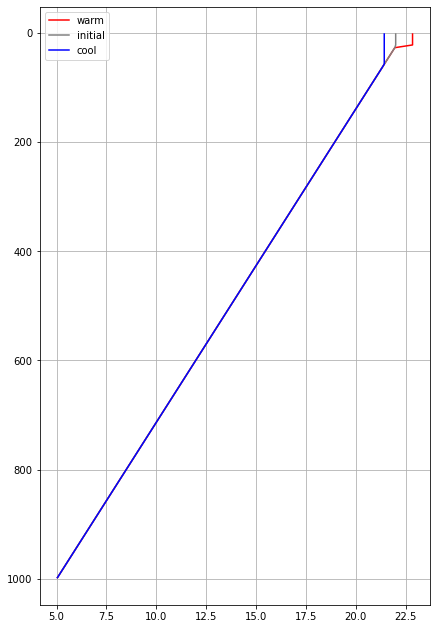

In [26]:
plt.figure(figsize=(7,11))

timestep = 4
plt.plot(onedim_warm_nokb[:,timestep], z_t, label='warm', color='r')
plt.plot(onedim_cool_nokb[:,0], z_t, label='initial', color='gray')
plt.plot(onedim_cool_nokb[:,timestep], z_t, label='cool', color='b')

plt.gca().invert_yaxis()
plt.grid()
plt.legend()
         